In [1]:
!pip install -q kaggle

In [2]:
# kaggle.json 파일 업로드
from google.colab import files
files.upload()  # 여기서 kaggle.json 파일 업로드!

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yjkimliz03","key":"71f14de2ef33e4126809eda8b6a7c7e2"}'}

In [3]:
# 디렉토리 이동 및 권한 설정
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# 데이터셋 다운로드 (melanoma 데이터셋 예시)
!kaggle datasets download -d newyjkimliz03/isic-2020-resized

Dataset URL: https://www.kaggle.com/datasets/newyjkimliz03/isic-2020-resized
License(s): DbCL-1.0
 99% 224M/227M [00:11<00:00, 24.4MB/s]
100% 227M/227M [00:11<00:00, 21.5MB/s]


In [5]:
# 데이터셋 다운로드 (melanoma 데이터셋 예시)
!kaggle datasets download -d newyjkimliz03/isic-2019-resized

Dataset URL: https://www.kaggle.com/datasets/newyjkimliz03/isic-2019-resized
License(s): DbCL-1.0
 98% 73.0M/74.6M [00:04<00:00, 21.4MB/s]
100% 74.6M/74.6M [00:04<00:00, 17.9MB/s]


In [6]:
!unzip isic-2020-resized.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: isic-2020-resized/train-resized/ISIC_8512716.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8513112.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8513649.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8514170.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8514989.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8515165.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8515281.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8515582.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8515674.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8516181.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8516223.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8516516.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8516631.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8516659.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8516922.jpg  
  in

In [7]:
!unzip isic-2019-resized.zip

Archive:  isic-2019-resized.zip
  inflating: isic-2019-resized/csv_filter.py  
  inflating: isic-2019-resized/images_filter.py  
  inflating: isic-2019-resized/train-labels.csv  
  inflating: isic-2019-resized/train-resized/ISIC_0000002.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000004.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000013.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000022_downsampled.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000026_downsampled.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000029_downsampled.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000030_downsampled.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000031_downsampled.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000035_downsampled.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000036_downsampled.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000040_downsampled.jpg  
  inflating: isic-201

In [27]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.model_selection import train_test_split
from PIL import Image
from datetime import datetime
import time
import numpy as np
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

In [28]:
# Définit le dataset à partir des fichiers fournis
class CustomDataset(Dataset):
    def __init__(self, data_folder, dataframe, transform=None):
        self.data_folder = data_folder
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.dataframe.iloc[idx, 0] + ".jpg")
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

def format_time(seconds):
    minutes, seconds = divmod(int(seconds), 60)
    hours, minutes = divmod(minutes, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

In [29]:
print(datetime.now())

# Vérifie si un GPU est disponible, et définit la variable device en conséquence
print("Running on GPU:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# writer = SummaryWriter("logs3", comment="EfficientNet-b0")
writer = SummaryWriter("logs3", comment="ResNet50")

2025-03-08 12:46:17.584141
Running on GPU: True


In [30]:
# Liens des images et des labels
data_folder_2020 = "/content/isic-2020-resized/train-resized"
label_file_2020 = "/content/isic-2020-resized/train-labels.csv"

data_folder_2019 = "/content/isic-2019-resized/train-resized"
label_file_2019 = "/content/isic-2019-resized/train-labels.csv"

In [31]:
# 데이터 로드
labels_2020 = pd.read_csv(label_file_2020)
labels_2019 = pd.read_csv(label_file_2019)

# 2020년 데이터: train (70%), validation (20%), test (10%)으로 나누기
train_dataframe_2020, temp_dataframe_2020 = train_test_split(
    labels_2020, test_size=0.3, random_state=42, stratify=labels_2020['target'])

val_dataframe_2020, test_dataframe_2020 = train_test_split(
    temp_dataframe_2020, test_size=1/3, random_state=42, stratify=temp_dataframe_2020['target'])

# 2019년 데이터: train (70%), validation (20%), test (10%)으로 나누기
train_dataframe_2019, temp_dataframe_2019 = train_test_split(
    labels_2019, test_size=0.3, random_state=42, stratify=labels_2019['target'])

val_dataframe_2019, test_dataframe_2019 = train_test_split(
    temp_dataframe_2019, test_size=1/3, random_state=42, stratify=temp_dataframe_2019['target'])

In [32]:
# ✅ 데이터 증강 적용 (훈련 데이터에만 적용)
train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(30),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ✅ 검증 & 테스트 데이터는 증강 없이 기본 변환만 적용
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [33]:
# Train 데이터셋 생성 (2020 + 2019)
train_dataset_2020 = CustomDataset(data_folder_2020, train_dataframe_2020, train_transform)
train_dataset_2019 = CustomDataset(data_folder_2019, train_dataframe_2019, train_transform)
train_dataset = ConcatDataset([train_dataset_2020, train_dataset_2019])

# Validation 데이터셋 생성 (2020 + 2019)
val_dataset_2020 = CustomDataset(data_folder_2020, val_dataframe_2020, val_test_transform)
val_dataset_2019 = CustomDataset(data_folder_2019, val_dataframe_2019, val_test_transform)
val_dataset = ConcatDataset([val_dataset_2020, val_dataset_2019])

# Test 데이터셋 생성 (2020 + 2019)
test_dataset_2020 = CustomDataset(data_folder_2020, test_dataframe_2020, val_test_transform)
test_dataset_2019 = CustomDataset(data_folder_2019, test_dataframe_2019, val_test_transform)
test_dataset = ConcatDataset([test_dataset_2020, test_dataset_2019])

In [34]:
# ✅ WeightedRandomSampler 적용 (클래스 불균형 보정)
batch_size = 128

all_train_labels = pd.concat([train_dataframe_2020, train_dataframe_2019])['target']
class_counts = all_train_labels.value_counts()
# weights = 1.0 / class_counts
weights = sum(class_counts) / class_counts  # 전체 샘플 수 / 각 클래스 샘플 수
sample_weights = all_train_labels.map(weights)
sampler = WeightedRandomSampler(torch.tensor(sample_weights.values, dtype=torch.float32), len(all_train_labels))

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


## EfficientNet

In [35]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # EfficientNet
# lr = 0.001
# l2_reg = 0.0001
# num_epochs = 5

# # 모델 초기화
# model = models.efficientnet_v2_m(weights='IMAGENET1K_V1')
# model.classifier[1] = nn.Linear(1280, 2)

# model = model.to(device)

# # 손실 함수 및 옵티마이저
# # criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 13.0]).to(device))
# # criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights.values).to(device))
# criterion = nn.CrossEntropyLoss(
#     weight=torch.tensor(weights.values, dtype=torch.float32).to(device)
# )
# optimizer = AdamW(model.parameters(), lr=lr, weight_decay=l2_reg)
# # scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

## ResNet

In [36]:
lr = 0.001
l2_reg = 0.0001
num_epochs = 20

# ✅ ResNet50 모델 초기화
weights = models.ResNet50_Weights.IMAGENET1K_V1  # IMAGENET1K_V1 웨이트 사용
model = models.resnet50(weights=weights)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2개의 클래스 (Benign, Melanoma)
model = model.to(device)

# ✅ 데이터셋에서 자동으로 클래스 가중치 계산
all_train_labels = pd.concat([train_dataframe_2020, train_dataframe_2019])['target']
class_counts = all_train_labels.value_counts()
weights = sum(class_counts) / class_counts  # 전체 샘플 수 / 각 클래스 샘플 수

# ✅ 가중치를 torch.Tensor로 변환하여 손실 함수에 적용
class_weights = torch.tensor(weights.to_numpy(), dtype=torch.float32).to(device)

# ✅ 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=l2_reg)

## LeNet

In [37]:
# import torch
# from torch import nn
# import torch.nn.functional as F

# class LeNet_5(nn.Module):
#     def __init__(self):
#         super(LeNet_5, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1)  # ✅ RGB 입력 (3채널)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
#         self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)
#         self.fc1 = nn.Linear(120, 84)
#         self.fc2 = nn.Linear(84, 2)  # ✅ 2개의 클래스 (Benign, Melanoma)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.avg_pool2d(x, 2, 2)
#         x = F.relu(self.conv2(x))
#         x = F.avg_pool2d(x, 2, 2)
#         x = F.relu(self.conv3(x))
#         x = x.view(x.size(0), -1)  # ✅ (batch_size, 120) 형태로 변환
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)  # ✅ CrossEntropyLoss를 사용하므로 softmax 제거
#         return x

# # ✅ 모델 생성 및 확인
# model = LeNet_5().to(device)

In [38]:
# train_transform = transforms.Compose([
#     transforms.Resize((32, 32)),  # ✅ LeNet-5에 맞게 크기 축소
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# val_test_transform = transforms.Compose([
#     transforms.Resize((32, 32)),  # ✅ LeNet-5에 맞게 크기 축소
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

In [39]:
# lr = 0.001
# l2_reg = 0.0001
# num_epochs = 20

# # ✅ 클래스 가중치 자동 계산
# all_train_labels = pd.concat([train_dataframe_2020, train_dataframe_2019])['target']
# class_counts = all_train_labels.value_counts()
# weights = sum(class_counts) / class_counts  # 전체 샘플 수 / 각 클래스 샘플 수

# # ✅ 가중치를 torch.Tensor로 변환하여 손실 함수에 적용
# class_weights = torch.tensor(weights.to_numpy(), dtype=torch.float32).to(device)

# # ✅ 손실 함수 및 옵티마이저 설정
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)

## DataSet 확인

In [40]:
# ✅ 타겟(0과 1) 개수 및 2020/2019 데이터 비율 출력
def count_targets_v2(df_2020, df_2019, name):
    total_2020 = len(df_2020)
    total_2019 = len(df_2019)
    total_all = total_2020 + total_2019  # 전체 데이터 개수

    target_counts_2020 = df_2020['target'].value_counts().to_dict()
    target_counts_2019 = df_2019['target'].value_counts().to_dict()

    print(f"\n {name} dataset:")
    print(f"   - Total: {total_all} images")
    print(f"   - 2020 데이터: {total_2020} images ({total_2020 / total_all * 100:.2f}%)")
    print(f"   - 2019 데이터: {total_2019} images ({total_2019 / total_all * 100:.2f}%)")
    print(f"   - Target 0 (정상) - 2020: {target_counts_2020.get(0, 0)}, 2019: {target_counts_2019.get(0, 0)}, Total: {target_counts_2020.get(0, 0) + target_counts_2019.get(0, 0)}")
    print(f"   - Target 1 (Melanoma) - 2020: {target_counts_2020.get(1, 0)}, 2019: {target_counts_2019.get(1, 0)}, Total: {target_counts_2020.get(1, 0) + target_counts_2019.get(1, 0)}")
    print("-" * 50)

print("데이터셋 준비 완료")

# 🔥 Train, Validation, Test 각각 2020과 2019 데이터를 합쳐서 출력
count_targets_v2(train_dataframe_2020, train_dataframe_2019, "Train")
count_targets_v2(val_dataframe_2020, val_dataframe_2019, "Validation")
count_targets_v2(test_dataframe_2020, test_dataframe_2019, "Test")

데이터셋 준비 완료

 Train dataset:
   - Total: 26353 images
   - 2020 데이터: 23188 images (87.99%)
   - 2019 데이터: 3165 images (12.01%)
   - Target 0 (정상) - 2020: 22779, 2019: 0, Total: 22779
   - Target 1 (Melanoma) - 2020: 409, 2019: 3165, Total: 3574
--------------------------------------------------

 Validation dataset:
   - Total: 7529 images
   - 2020 데이터: 6625 images (87.99%)
   - 2019 데이터: 904 images (12.01%)
   - Target 0 (정상) - 2020: 6508, 2019: 0, Total: 6508
   - Target 1 (Melanoma) - 2020: 117, 2019: 904, Total: 1021
--------------------------------------------------

 Test dataset:
   - Total: 3766 images
   - 2020 데이터: 3313 images (87.97%)
   - 2019 데이터: 453 images (12.03%)
   - Target 0 (정상) - 2020: 3255, 2019: 0, Total: 3255
   - Target 1 (Melanoma) - 2020: 58, 2019: 453, Total: 511
--------------------------------------------------


In [41]:
# from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# # 최적 모델 저장을 위한 변수
# best_auc = 0.0

# train_losses, val_losses, train_aucs, val_aucs = [], [], [], []

# print("Starting")
# start_time = time.time()
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0.0
#     all_labels = []
#     all_predictions = []
#     all_probs = []

#     # 랜덤 샘플링된 DataLoader 생성
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)

#     # Train Loop
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#         # 예측값 저장
#         _, predicted = torch.max(outputs, 1)
#         probs = torch.softmax(outputs, dim=1)[:, 1]  # Melanoma 확률

#         all_labels.extend(labels.cpu().numpy())
#         all_predictions.extend(predicted.cpu().numpy())
#         all_probs.extend(probs.detach().cpu().numpy())  # ✅ detach() 추가

#     train_losses.append(total_loss / len(train_loader))
#     train_auc = roc_auc_score(all_labels, all_probs)  # ✅ Train AUC 계산
#     train_aucs.append(train_auc)  # ✅ 저장

#     # 성능 지표 계산
#     accuracy = accuracy_score(all_labels, all_predictions) * 100
#     auc = roc_auc_score(all_labels, all_probs)
#     precision = precision_score(all_labels, all_predictions, zero_division=0)
#     recall = recall_score(all_labels, all_predictions, zero_division=0)
#     f1 = f1_score(all_labels, all_predictions, zero_division=0)

#     print(f"Training - Epoch {epoch + 1}: Loss={total_loss/len(train_loader):.4f}, "
#           f"Acc={accuracy:.2f}%, AUC={auc:.4f}, Precision={precision:.4f}, "
#           f"Recall={recall:.4f}, F1={f1:.4f}, LR={optimizer.param_groups[0]['lr']}")

#     # TensorBoard 기록
#     writer.add_scalar("Training/Loss", total_loss/len(train_loader), epoch)
#     writer.add_scalar("Training/Accuracy", accuracy, epoch)
#     writer.add_scalar("Training/AUC", auc, epoch)
#     writer.add_scalar("Training/Precision", precision, epoch)
#     writer.add_scalar("Training/Recall", recall, epoch)
#     writer.add_scalar("Training/F1", f1, epoch)
#     writer.add_scalar("Learning Rate", optimizer.param_groups[0]["lr"], epoch)

#     torch.save(model.state_dict(), f'EfficientNet-{epoch + 1}-l2reg0.001.pth')

#     # Validation Loop
#     model.eval()
#     total_val_loss = 0.0
#     val_labels = []
#     val_predictions = []
#     val_probs = []

#     val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)

#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             val_outputs = model(inputs)
#             val_loss = criterion(val_outputs, labels)
#             total_val_loss += val_loss.item()

#             # 예측값 저장
#             _, predicted = torch.max(val_outputs, 1)
#             probs = torch.softmax(val_outputs, dim=1)[:, 1]  # Melanoma 확률

#             val_labels.extend(labels.cpu().numpy())
#             val_predictions.extend(predicted.cpu().numpy())
#             val_probs.extend(probs.detach().cpu().numpy())  # ✅ detach() 추가

#     # 성능 지표 계산
#     val_accuracy = accuracy_score(val_labels, val_predictions) * 100
#     val_auc = roc_auc_score(val_labels, val_probs)
#     val_precision = precision_score(val_labels, val_predictions, zero_division=0)
#     val_recall = recall_score(val_labels, val_predictions, zero_division=0)
#     val_f1 = f1_score(val_labels, val_predictions, zero_division=0)

#     # Validation Loss 저장
#     val_losses.append(total_val_loss / len(val_loader))
#     val_aucs.append(val_auc)  # ✅ 저장

#     # 🔥 **Validation Loss 기준으로 LR 감소** 🔥
#     scheduler.step(total_val_loss / len(val_loader))  # ✅ 추가

#     if val_auc > best_auc:
#         best_auc = val_auc
#         torch.save(model.state_dict(), 'best_model.pth')

#     print(f"Validation - Epoch {epoch + 1}: Loss={total_val_loss/len(val_loader):.4f}, "
#           f"Acc={val_accuracy:.2f}%, AUC={val_auc:.4f}, Precision={val_precision:.4f}, "
#           f"Recall={val_recall:.4f}, F1={val_f1:.4f}, LR={optimizer.param_groups[0]['lr']}")  # ✅ LR 추가 출력

#     # TensorBoard 기록
#     writer.add_scalar("Validation/Loss", total_val_loss/len(val_loader), epoch)
#     writer.add_scalar("Validation/Accuracy", val_accuracy, epoch)
#     writer.add_scalar("Validation/AUC", val_auc, epoch)
#     writer.add_scalar("Validation/Precision", val_precision, epoch)
#     writer.add_scalar("Validation/Recall", val_recall, epoch)
#     writer.add_scalar("Validation/F1", val_f1, epoch)

# print("Training completed!")
# writer.close()

In [42]:
# 오리지널

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# 최적 모델 저장을 위한 변수
best_auc = 0.0
best_val_loss = float('inf')  # ✅ 초기값을 무한대로 설정


train_losses, val_losses, train_aucs, val_aucs = [], [], [], []

print("Starting")
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    all_labels = []
    all_predictions = []
    all_probs = []

    # 랜덤 샘플링된 DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)


    # Train Loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # inputs = inputs.to(torch.float32)

        # inputs, labels = inputs.to(device), labels.to(device).long()  # labels를 long()으로 변환
        optimizer.zero_grad()
        outputs = model(inputs)
        # outputs = model(inputs).float()  # outputs을 float32로 변환
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # 예측값 저장
        _, predicted = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Melanoma 확률

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())  # ✅ detach() 추가

    train_losses.append(total_loss / len(train_loader))
    train_auc = roc_auc_score(all_labels, all_probs)  # ✅ Train AUC 계산
    train_aucs.append(train_auc)  # ✅ 저장

    # 성능 지표 계산
    accuracy = accuracy_score(all_labels, all_predictions) * 100
    auc = roc_auc_score(all_labels, all_probs)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)

    print(f"Training - Epoch {epoch + 1}: Loss={total_loss/len(train_loader):.4f}, "
          f"Acc={accuracy:.2f}%, AUC={auc:.4f}, Precision={precision:.4f}, "
          f"Recall={recall:.4f}, F1={f1:.4f}, LR={optimizer.param_groups[0]['lr']}")

    # TensorBoard 기록
    writer.add_scalar("Training/Loss", total_loss/len(train_loader), epoch)
    writer.add_scalar("Training/Accuracy", accuracy, epoch)
    writer.add_scalar("Training/AUC", auc, epoch)
    writer.add_scalar("Training/Precision", precision, epoch)
    writer.add_scalar("Training/Recall", recall, epoch)
    writer.add_scalar("Training/F1", f1, epoch)
    writer.add_scalar("Learning Rate", optimizer.param_groups[0]["lr"], epoch)

    torch.save(model.state_dict(), f'EfficientNet-{epoch + 1}-l2reg0.001.pth')
    # scheduler.step()

    # Boucle de validation
    model.eval()
    total_val_loss = 0.0
    val_labels = []
    val_predictions = []
    val_probs = []

    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
    # Validation Loop
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, labels)
            total_val_loss += val_loss.item()

            # 예측값 저장
            _, predicted = torch.max(val_outputs, 1)
            probs = torch.softmax(val_outputs, dim=1)[:, 1]  # Melanoma 확률

            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())
            val_probs.extend(probs.detach().cpu().numpy())  # ✅ detach() 추가

    # 성능 지표 계산
    val_accuracy = accuracy_score(val_labels, val_predictions) * 100
    val_auc = roc_auc_score(val_labels, val_probs)
    val_precision = precision_score(val_labels, val_predictions, zero_division=0)
    val_recall = recall_score(val_labels, val_predictions, zero_division=0)
    val_f1 = f1_score(val_labels, val_predictions, zero_division=0)
    #val loss, auc 저장
    val_loss = total_val_loss / len(val_loader)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)  # ✅ 저장

    # if val_auc > best_auc:
    #     best_auc = val_auc
    #     torch.save(model.state_dict(), 'best_model.pth')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Validation - Epoch {epoch + 1}: Loss={total_val_loss/len(val_loader):.4f}, "
          f"Acc={val_accuracy:.2f}%, AUC={val_auc:.4f}, Precision={val_precision:.4f}, "
          f"Recall={val_recall:.4f}, F1={val_f1:.4f}")

    # TensorBoard 기록
    writer.add_scalar("Validation/Loss", total_val_loss/len(val_loader), epoch)
    writer.add_scalar("Validation/Accuracy", val_accuracy, epoch)
    writer.add_scalar("Validation/AUC", val_auc, epoch)
    writer.add_scalar("Validation/Precision", val_precision, epoch)
    writer.add_scalar("Validation/Recall", val_recall, epoch)
    writer.add_scalar("Validation/F1", val_f1, epoch)

print("Training completed!")
writer.close()

Starting
Training - Epoch 1: Loss=0.1335, Acc=85.22%, AUC=0.9755, Precision=0.7860, Recall=0.9674, F1=0.8673, LR=0.001
Validation - Epoch 1: Loss=0.4441, Acc=73.74%, AUC=0.9791, Precision=0.3387, Recall=0.9833, F1=0.5039
Training - Epoch 2: Loss=0.1092, Acc=86.97%, AUC=0.9832, Precision=0.8048, Recall=0.9763, F1=0.8823, LR=0.001
Validation - Epoch 2: Loss=0.3756, Acc=81.35%, AUC=0.9815, Precision=0.4189, Recall=0.9687, F1=0.5849
Training - Epoch 3: Loss=0.0915, Acc=89.32%, AUC=0.9884, Precision=0.8354, Recall=0.9809, F1=0.9023, LR=0.001
Validation - Epoch 3: Loss=0.4874, Acc=76.04%, AUC=0.9810, Precision=0.3591, Recall=0.9775, F1=0.5253
Training - Epoch 4: Loss=0.0771, Acc=91.98%, AUC=0.9922, Precision=0.8732, Recall=0.9811, F1=0.9240, LR=0.001
Validation - Epoch 4: Loss=0.2592, Acc=93.66%, AUC=0.9816, Precision=0.7039, Recall=0.9197, F1=0.7975
Training - Epoch 5: Loss=0.0597, Acc=94.40%, AUC=0.9953, Precision=0.9094, Recall=0.9860, F1=0.9461, LR=0.001
Validation - Epoch 5: Loss=0.4282

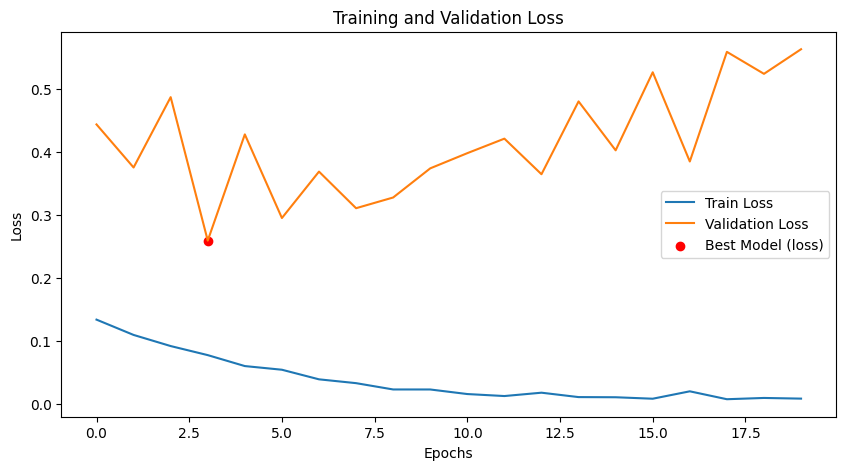

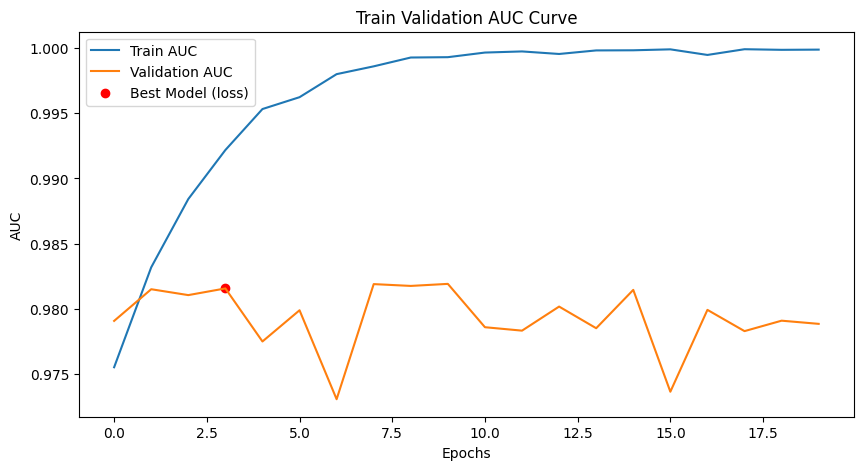

In [43]:
import matplotlib.pyplot as plt

# 🔥 최적 Loss 모델이 저장된 Epoch 찾기
# best_epoch = val_aucs.index(best_auc)
best_epoch = val_losses.index(best_val_loss)


# ✅ Training & Validation Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.scatter(best_epoch, val_losses[best_epoch], color='red', marker='o', label='Best Model (loss)')  # 🔴 추가
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# ✅ Train & Validation AUC Curve
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_aucs, label='Train AUC')
plt.plot(range(num_epochs), val_aucs, label='Validation AUC')
plt.scatter(best_epoch, val_aucs[best_epoch], color='red', marker='o', label='Best Model (loss)')  # 🔴 추가
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('Train Validation AUC Curve')
plt.show()

In [44]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# 🔥 저장된 최적 모델 불러오기
model.load_state_dict(torch.load('best_model.pth'))  # ✅ best_model.pth 불러오기
model = model.to(device)
model.eval()  # 모델을 평가 모드로 변경

total_test_loss = 0.0
correct_test = 0
correct_test_class0 = 0
correct_test_class1 = 0
total_test = 0
total_test_class0 = 0
total_test_class1 = 0

all_test_labels = []
all_test_predictions = []
all_test_probs = []

print("\n[Start Test Evaluation]")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        test_outputs = model(inputs)
        test_loss = criterion(test_outputs, labels)
        total_test_loss += test_loss.item()

        # 예측값 저장
        _, predicted = torch.max(test_outputs, 1)
        probs = torch.softmax(test_outputs, dim=1)[:, 1]  # Melanoma 확률

        all_test_labels.extend(labels.cpu().numpy())
        all_test_predictions.extend(predicted.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())

        for i in range(len(predicted)):
            if labels[i] == 0:
                total_test_class0 += 1
                correct_test_class0 += (predicted[i] == labels[i]).item()
            elif labels[i] == 1:
                total_test_class1 += 1
                correct_test_class1 += (predicted[i] == labels[i]).item()

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# 성능 지표 계산
test_accuracy = accuracy_score(all_test_labels, all_test_predictions) * 100
test_auc = roc_auc_score(all_test_labels, all_test_probs)
test_precision = precision_score(all_test_labels, all_test_predictions, zero_division=0)
test_recall = recall_score(all_test_labels, all_test_predictions, zero_division=0)
test_f1 = f1_score(all_test_labels, all_test_predictions, zero_division=0)

test_accuracy_class0 = correct_test_class0 / total_test_class0 * 100
test_accuracy_class1 = correct_test_class1 / total_test_class1 * 100

# 최종 Test 결과 출력
print(f"\n[Test Results]")
print(f"Loss: {total_test_loss/len(test_loader):.4f}")
print(f"Accuracy: {test_accuracy:.2f}% (Class 0: {test_accuracy_class0:.2f}%, Class 1: {test_accuracy_class1:.2f}%)")
print(f"AUC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


[Start Test Evaluation]


<ipython-input-44-75d328704458>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))  # ✅ best_model.pth 불러오기



[Test Results]
Loss: 0.2396
Accuracy: 93.79% (Class 0: 94.07%, Class 1: 91.98%)
AUC: 0.9830
Precision: 0.7089
Recall: 0.9198
F1 Score: 0.8007



[Test Results]
Loss: 0.2396
Accuracy: 93.79% (Class 0: 94.07%, Class 1: 91.98%)
AUC: 0.9830
Precision: 0.7089
Recall: 0.9198
F1 Score: 0.8007


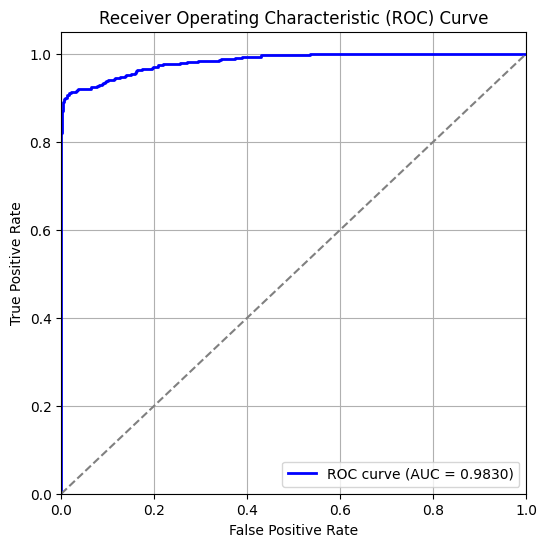

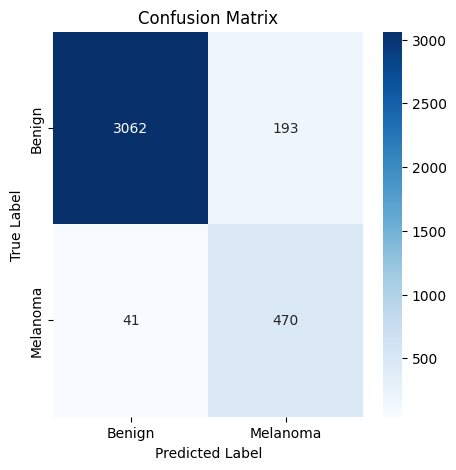

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# 1️⃣ Test 결과 출력
print(f"\n[Test Results]")
print(f"Loss: {total_test_loss/len(test_loader):.4f}")
print(f"Accuracy: {test_accuracy:.2f}% (Class 0: {test_accuracy_class0:.2f}%, Class 1: {test_accuracy_class1:.2f}%)")
print(f"AUC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# 2️⃣ ROC Curve 시각화
fpr, tpr, _ = roc_curve(all_test_labels, all_test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선 (랜덤 예측)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 3️⃣ Confusion Matrix 시각화
cm = confusion_matrix(all_test_labels, all_test_predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Melanoma"], yticklabels=["Benign", "Melanoma"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()